In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
import csv
os.environ['KERAS_BACKEND']='tensorflow'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 25000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

Using TensorFlow backend.


In [0]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [4]:
# reading data
df = pd.read_csv('/gdrive/My Drive/movie_review_small.csv',encoding = "ISO-8859-1")
df = df.dropna()
df = df.reset_index(drop=True)
print(df.shape)
print(len(set(df['CLASS'])))
df

(5002, 6)
2


,fold_id,cv_tag,html_id,sent_id,CONTENT,CLASS
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos
5,0,cv000,29590,5,if you can get past the whole comic book thing...,pos
6,0,cv000,29590,6,getting the hughes brothers to direct this see...,pos
7,0,cv000,29590,7,"the ghetto in question is , of course , whitec...",pos
8,0,cv000,29590,8,"it's a filthy , sooty place where the whores (...",pos
9,0,cv000,29590,9,"when the first stiff turns up , copper peter g...",pos


In [0]:
macronum=sorted(set(df['CLASS']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['CLASS']=df['CLASS'].apply(fun)

In [6]:
texts = []
labels = []


for idx in range(df.CONTENT.shape[0]):
    text = BeautifulSoup(df.CONTENT[idx])
    texts.append(clean_str(str(text.get_text().encode())))


for idx in df['CLASS']:
    labels.append(idx)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [7]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

print(len(word_index))

13350


In [0]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


labels = to_categorical(np.asarray(labels))

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]


In [0]:
embeddings_index = {}
f = open('/gdrive/My Drive/glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


In [0]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
# To get f1 score
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
import tensorflow as tf
from tensorflow.python.keras.layers import Input, LSTM, Bidirectional, Dense, Embedding
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(len(macronum), activation='sigmoid')(l_lstm)
model = tf.keras.Model(sequence_input, preds)
model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['acc',f1])


In [32]:
import os
import tensorflow as tf
# This address identifies the TPU we'll use when configuring TensorFlow.
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

INFO:tensorflow:Querying Tensorflow master (grpc://10.72.215.130:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10996675620043401505)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 7425545139382405821)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 3718125649310325058)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1512487344471295170)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 1311920841398989654)
INFO:tensorflow:*** Available Device: _DeviceAttributes(

In [33]:
history=tpu_model.fit(x_train, y_train, validation_split=0.2,epochs=10, batch_size=128)

Train on 4002 samples, validate on 801 samples
Epoch 1/10
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id_20'), TensorSpec(shape=(16, 1000), dtype=tf.int32, name='input_3_10'), TensorSpec(shape=(16, 2), dtype=tf.float32, name='dense_1_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning RMSprop {'lr': 0.0010000000474974513, 'rho': 0.8999999761581421, 'decay': 0.0, 'epsilon': 1e-07}
INFO:tensorflow:Remapping placeholder for input_3
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.RMSprop object at 0x7fce7addfb00> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 17.285407066345215 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0.0010000000474974513 {0.001}
INFO:tensorflow:CPU -> TPU rho: 0.8999999761581421 {0.9}
INFO:tensorflow:CPU -> TPU decay: 0.0 {0.0}
3840/4002 [================

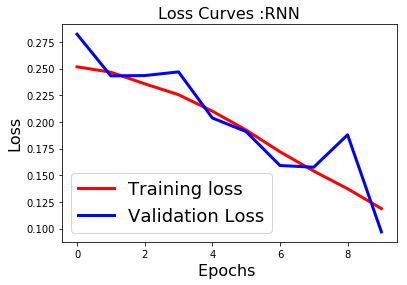

In [34]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
fig1.savefig('loss_rnn.png')
plt.show()

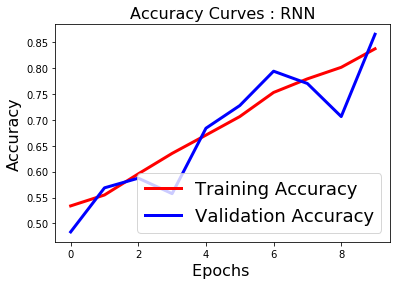

In [35]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig2.savefig('accuracy_rnn.png')
plt.show()

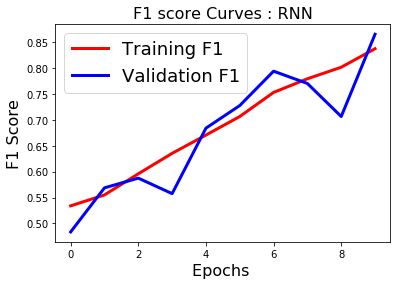

In [36]:
fig3=plt.figure()
plt.plot(history.history['f1'],'r',linewidth=3.0)
plt.plot(history.history['val_f1'],'b',linewidth=3.0)
plt.legend(['Training F1', 'Validation F1'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('F1 Score',fontsize=16)
plt.title('F1 score Curves : RNN',fontsize=16)
fig3.savefig('f1_rnn.png')
plt.show()

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         1335100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 1,496,302
Trainable params: 1,496,302
Non-trainable params: 0
_________________________________________________________________


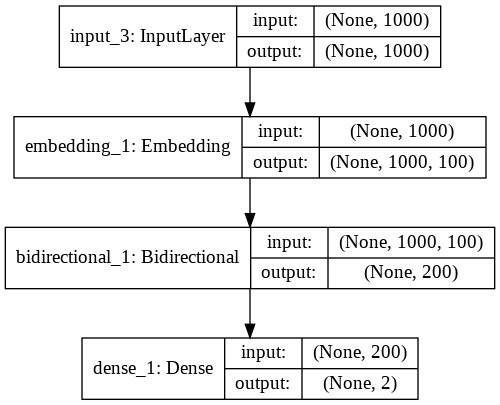

In [38]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')